In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
tf_device = '/gpu:2'

In [13]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from uncertainty_from_distance import uncertainty_from_distances
import matplotlib.pyplot as plt
from sampling_unc import sample_uniform
from attack import attack_fn
from sampling_unc import sample_high_unc
from scipy import stats

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(100)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(100)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [6]:
fc_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Softmax(axis = -1)
])
fc_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

fc_model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
600/600 [==============================] - 4s 3ms/step - loss: 1.6041 - sparse_categorical_accuracy: 0.8848 - val_loss: 1.5394 - val_sparse_categorical_accuracy: 0.9325
Epoch 2/6
600/600 [==============================] - 2s 2ms/step - loss: 1.5282 - sparse_categorical_accuracy: 0.9410 - val_loss: 1.5187 - val_sparse_categorical_accuracy: 0.9483
Epoch 3/6
600/600 [==============================] - 2s 3ms/step - loss: 1.5131 - sparse_categorical_accuracy: 0.9539 - val_loss: 1.5097 - val_sparse_categorical_accuracy: 0.9562
Epoch 4/6
600/600 [==============================] - 2s 3ms/step - loss: 1.5045 - sparse_categorical_accuracy: 0.9616 - val_loss: 1.5048 - val_sparse_categorical_accuracy: 0.9601
Epoch 5/6
600/600 [==============================] - 2s 2ms/step - loss: 1.4978 - sparse_categorical_accuracy: 0.9676 - val_loss: 1.5008 - val_sparse_categorical_accuracy: 0.9639
Epoch 6/6
600/600 [==============================] - 2s 3ms/step - loss: 1.4934 - sparse_categorical_accu

In [7]:
fc_distance_obj = uncertainty_from_distances(fc_model, 100, 20, 28, 1)

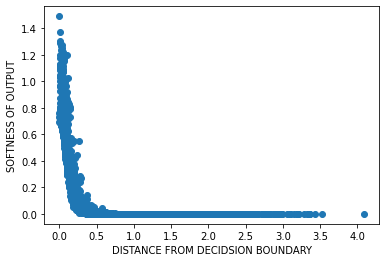

<Figure size 432x288 with 0 Axes>

In [15]:
fc_unc_list = np.array([0])
fc_soft_list = np.zeros([1, 10])
for (imgs, labels) in ds_test:
    outs = fc_model(imgs)
    fc_soft_list = np.append(fc_soft_list, fc_model(imgs), axis = 0)
    fc_unc_list = np.append(fc_unc_list, tf.make_ndarray(tf.make_tensor_proto(fc_distance_obj.get_uncertainty(imgs))), axis = 0)
fc_soft_list = stats.entropy(fc_soft_list, axis = 1)

plt.scatter(fc_unc_list, fc_soft_list)
plt.xlabel('DISTANCE FROM DECIDSION BOUNDARY')
plt.ylabel('SOFTNESS OF OUTPUT')
plt.show()
plt.savefig('fc_unc_vs_soft.png')

In [16]:
cnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(10, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.Flatten(input_shape=(26, 26, 10)),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Softmax(axis = -1)
])
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

cnn_model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
600/600 [==============================] - 6s 10ms/step - loss: 1.5911 - sparse_categorical_accuracy: 0.8950 - val_loss: 1.5281 - val_sparse_categorical_accuracy: 0.9400
Epoch 2/6
600/600 [==============================] - 5s 9ms/step - loss: 1.5216 - sparse_categorical_accuracy: 0.9447 - val_loss: 1.5104 - val_sparse_categorical_accuracy: 0.9550
Epoch 3/6
600/600 [==============================] - 5s 8ms/step - loss: 1.5055 - sparse_categorical_accuracy: 0.9602 - val_loss: 1.5027 - val_sparse_categorical_accuracy: 0.9615
Epoch 4/6
600/600 [==============================] - 5s 8ms/step - loss: 1.4964 - sparse_categorical_accuracy: 0.9687 - val_loss: 1.4954 - val_sparse_categorical_accuracy: 0.9681
Epoch 5/6
600/600 [==============================] - 5s 7ms/step - loss: 1.4908 - sparse_categorical_accuracy: 0.9742 - val_loss: 1.4933 - val_sparse_categorical_accuracy: 0.9706
Epoch 6/6
600/600 [==============================] - 5s 9ms/step - loss: 1.4872 - sparse_categorical_acc

In [17]:
cnn_distance_obj = uncertainty_from_distances(cnn_model, 100, 20, 28, 1)

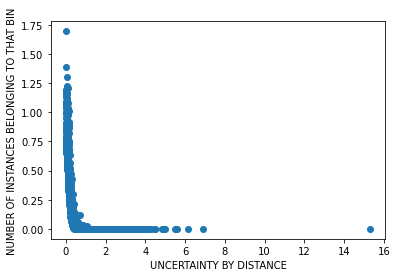

<Figure size 432x288 with 0 Axes>

In [18]:
cnn_unc_list = np.array([0])
cnn_soft_list = np.zeros([1, 10])
for (imgs, labels) in ds_test:
    outs = cnn_model(imgs)
    cnn_soft_list = np.append(cnn_soft_list, cnn_model(imgs), axis = 0)
    cnn_unc_list = np.append(cnn_unc_list, tf.make_ndarray(tf.make_tensor_proto(cnn_distance_obj.get_uncertainty(imgs))), axis = 0)
cnn_soft_list = scipy.stats.entropy(cnn_soft_list, axis = 1)

plt.scatter(cnn_unc_list, cnn_soft_list)
plt.xlabel('UNCERTAINTY BY DISTANCE')
plt.ylabel('NUMBER OF INSTANCES BELONGING TO THAT BIN')
plt.show()
plt.savefig('cnn_unc_vs_soft.png')

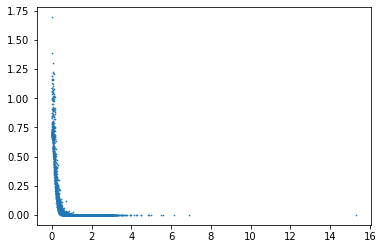

In [22]:
plt.scatter(cnn_unc_list, cnn_soft_list, s = 0.45)

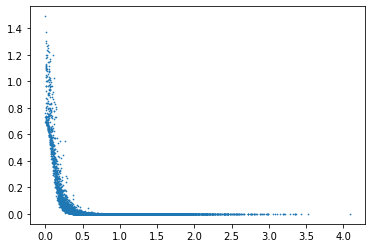

In [23]:
plt.scatter(fc_unc_list, fc_soft_list, s = 0.45)